# Numerical expression inference problem: numerical constant finding with ephemeral numerical constant (ENC)
In this example, we aim to identify a mathematicalfunction $f$ from the given input-ouput data such that the function $f$ can produce the expected ouput given a certain input. This is a typical [symbolic regression](https://en.wikipedia.org/wiki/Symbolic_regression) problem:

> Symbolic regression is a type of regression analysis that searches the space of mathematical expressions to find the model that best fits a given dataset, both in terms of accuracy and simplicity.

which is most commonly solved with genetic programming and its variant, gene expression programming (GEP), presented here. 

Before continuing this example, you'd better first go through the two fundamental tutorials listed below to get familiar with GEP and *geppy*:
+ [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html)
+ [Overview of geppy for Gene Expression Programming (GEP)](https://geppy.readthedocs.io/en/latest/overview.html)

The main difference of this problem w.r.t the [Boolean function identification](Boolean_function_identification.ipynb) problem is that generally a mathematical model involves constant coefficients, which is more challenging for both genetic programming (GP) and GEP. The standard way to handle numerical constants in GP is to use ephemeral numerical constants (ENCs), whose value are initialized randomly and can be updated during the evolution process. Though experimental results show that the GEP-RNC algorithm is more efficient than using ENCs, it is still supported by *geppy* and can do the work for simple problems, like models which only involve integer constants. To learn about the GEP-RNC algorithm recommended for numerical constant finding in GEP, please check the example [GEP-RNC for numerical expression inference](./numerical_expression_inference.ipynb).

The key to adopt ENCs in *geppy* is:
+ add one or more ephemerals with `PrimitiveSet.add_ephemeral` (usually one is enough)
+ [optional] update the ephemerals during evolution by the `mutate_uniform_ephemeral` operator.

In [1]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

# Synthetic dataset

For this simple task, we first choose a ground truth function $f$ to generate a dataset $D$. Then, 50 input-output exampels are generated randomly.

In [2]:
def f(x):
    """Ground truth function"""
    return -2 * x ** 2 + 11 * x + 13

In [3]:
n_cases = 100
X = np.random.uniform(-10, 10, size=n_cases)   # random numbers in range [-10, 10)
Y = f(X) + np.random.normal(size=n_cases)   # Gaussian noise

# Creating the primitives set
The first step in GEP (or GP as well) is to specify the primitive set, which contains the elementary building blocks to formulate the model. For this problem, we have:
+ function set: the standard arithmetic operators addition (+), subtraction (-), multiplication (*), and division (/).
+ terminal set: only the single input 'x' and random numerical constants (RNC).

NOTE:

- We define a *protected division* to avoid dividing by zero.
- Even there may be multiple RNCs in the model, we only need to call `PrimitiveSet.add_rnc` once.

In [4]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

In [5]:
import operator 

pset = gep.PrimitiveSet('Main', input_names=['x'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_ephemeral_terminal(name='enc', gen=lambda: random.randint(-10, 10)) # each ENC is a random integer within [-10, 10]

# Create the individual and population
Our objective is to **minimize** the MSE (mean squared error) for data fitting.
## Define the indiviudal class, a subclass of *gep.Chromosome*

In [6]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

## Register the individual and population creation operations
In DEAP, it is recommended to register the operations used in evolution into a *toolbox* to make full use of DEAP functionality. The configuration of individuals in this problem is:
+ head length: 6
+ number of genes in each chromosome: 2

Generally, more complicated problems require a larger head length and longer chromosomes formed with more genes.

In [7]:
h = 7 # head length
n_genes = 2   # number of genes in a chromosome

In [8]:
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

# Define the fitness evaluation function
In DEAP, the single objective optimization problem is just a special case of more general multiobjective ones. Since *geppy* is built on top of DEAP, it conforms to this convention. **Even if the fitness only contains one measure, keep in mind that DEAP stores it as an iterable.** 

Knowing that, you can understand why the evaluation function must return a tuple value (even if it is a 1-tuple). That's also why we set ``weights=(-1,)`` when creating the ``FitnessMax`` class.

In [9]:
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    Yp = np.array(list(map(func, X)))
    return np.mean(np.abs(Y - Yp)),

In [10]:
toolbox.register('evaluate', evaluate)

# Register genetic operators
Compared with GP and other genetic algorithms, GEP has its own set of genetic operators aside from common mutation and crossover. For details, please check the tutorial [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html).

In the following code, the selection operator is ``tools.selTournament`` provided by DEAP, while all other operators are specially designed for GEP in *geppy*.

In [11]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.4)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
toolbox.register('mut_ephemeral', gep.mutate_uniform_ephemeral, ind_pb='1p')  # 1p: expected one point mutation in an individual
toolbox.pbs['mut_ephemeral'] = 1  # we can also give the probability via the pbs property

# Statistics to be inspected
We often need to monitor of progress of an evolutionary program. DEAP offers two classes to handle the boring work of recording statistics. Details are presented in [Computing statistics](http://deap.readthedocs.io/en/master/tutorials/basic/part3.html). In the following, we are intereted in the average/standard deviation/min/max of all the individuals' fitness in each generation.

In [12]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Launch evolution
We make use of *geppy*'s builtin algorithm ``gep_rnc`` here to perform the GEP-RNC evolution. A special class from DEAP, `HallOfFame`, is adopted to store the best individuals ever found. Besides, it should be noted that in GEP [*elitism*](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism) is highly recommended because some genetic operators in GEP are destructive and may destroy the best individual we have evolved.

In [13]:
# size of population and number of generations
n_pop = 100
n_gen = 100

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(3)   # only record the best three individuals ever found in all generations

# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	100   	123.653	258.663	36.2886	2210.09
1  	99    	123.275	421.45 	36.2886	4218.21
2  	99    	76.8484	36.3177	27.2292	270.464
3  	99    	84.1495	55.2211	27.2292	503.76 
4  	99    	75.0767	50.3076	25.7879	464.636
5  	99    	67.7947	31.7203	25.7879	247.595
6  	99    	70.6593	49.5508	19.4266	433.013
7  	99    	86.7988	170.453	19.4266	1735.32
8  	99    	89.0119	103.553	5.79722	737.448
9  	99    	70.2222	76.8899	5.79722	766.961
10 	99    	61.3173	33.9059	5.45261	202.068
11 	99    	63.8959	58.2055	1.26424	448.941
12 	99    	59.4774	60.92  	0.862385	417.644
13 	99    	73.1502	124.738	0.862385	1098.04
14 	99    	64.4326	108.114	0.862385	1070.77
15 	99    	61.571 	75.2669	0.862385	472.563
16 	99    	68.7805	96.52  	0.862385	603.352
17 	99    	83.1265	134.055	0.862385	856.275
18 	99    	65.4132	74.0187	0.862385	577.229
19 	99    	64.1222	77.6681	0.862385	585.138
20 	99    	53.3202	58.9018	0.862385	421.891
21 	99    	573.538	5035.18	0.862385	50668  
2

**Let's check the best individuals ever evolved.**

In [14]:
print(hof[0])

add(
	sub(8, mul(add(x, add(-10, x)), x)),
	add(5, x)
)


# *[optional]* Post-processing: simplification and visualization
## Symbolic simplification of the final solution
The original solution seems a little complicated, which may contain many redundancies, for example, `protected_div(x, x)` is just 1. We can perform symbolic simplification of the final result by `geppy.simplify` which depends on `sympy` package.

In [15]:
best_ind = hof[0]
symplified_best = gep.simplify(best_ind)
print('Symplified best individual: ')
print(symplified_best)

Symplified best individual: 
-2*x*(x - 5) + x + 13


As we can see from the above simplified expression, the *truth model* has been successfully found. Due to the existence of Gaussian noise, the minimum mean absolute error （MAE) is still not zero even the best individual represents the true model.

## Visualization
If you are interested in the expression tree corresponding to the individual, i.e., the genotype/phenotype system, *geppy* supports tree visualization by the `graph` and the `export_expression_tree` functions:

- `graph` only outputs the nodes and links information to describe the tree topology, with which you can render the tree with tools you like;
- `export_expression_tree` implements tree visualization with data generated by `graph` internally using the `graphviz` package. 

In [16]:
 # we want use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
gep.export_expression_tree(best_ind, rename_labels, 'data/numerical_expression_tree.png')

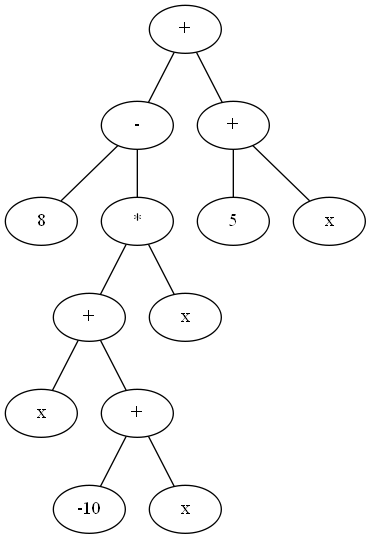

In [17]:
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png') 

# Discussion
If only integer constants are involved, then the GEP-RNC algorithm and the ENC-based algorithm can both be adopted. However, generally the GEP-RNC algorithm is more effective.

In other cases where the model is more complicated involving real coefficients and constants, then both of the above two algorithms will have difficulty in optimizing these constants. A better way is to incorporate a local optimization into GEP dedicated to constant number optimization. 

You may like to compare this solution with the one solved with GEP-RNC [GEP-RNC for numerical expression inference](./numerical_expression_inference.ipynb).